In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Datasets'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **GETTING DATA FROM API**

In [ ]:
import requests
import json

In [ ]:
def MakeAPICall(api):
    response = requests.get(api)
    if response.status_code == 200:
        return True, json.dumps(response.json(), sort_keys=True, indent=4)
    else:
        return False, response.status_code

In [ ]:
BASE = "http://api.weatherapi.com/v1/history.json"
KEY = '?key=5620bf0294994dab96190931232704'

In [ ]:
DATES = []

def getDate(yr):
    dates = []
    for mon in range(1, 13):
        if mon in [1, 3, 5, 7, 8, 10, 12]:
            for day in range(1, 32):
                date = '-'.join([str(yr), str(mon), str(day)])
                dates.append(date)
                
        elif mon in [4, 6, 9, 11]:
            for day in range(1, 31):
                date = '-'.join([str(yr), str(mon), str(day)])
                dates.append(date)
        else:
            for day in range(1, 29):
                date = '-'.join([str(yr), str(mon), str(day)])
                dates.append(date)
    
    return dates


dates = getDate(2022)
print(len(dates))

In [ ]:
index = dates.index('2022-7-20')
DATES = dates[index+1:].copy()

print(len(DATES))

dates = getDate(2023)
DATES.extend(dates)

print(len(DATES))

In [ ]:
def getTemp(city, rev=True):
    CITY = "&q=" + city
    temp = {}
    temp['Date'] = []
    temp['tmax'] = []
    temp['tavg'] = []
    temp['tmin'] = []

    t_dates = DATES.copy()
    for date in t_dates:
        DATE = "&dt=" + date
        mum = BASE + KEY + CITY + DATE
        # print(mum)
        # mum = "http://api.weatherapi.com/v1/history.json?key=5620bf0294994dab96190931232704&q=Mumbai&dt=2022-04-30"
        # print(mum)
        mum = MakeAPICall(mum)
        if mum[0]:
            res = json.loads(mum[1])
            # print(res)
            temp['Date'].append(date)
            temp['tmax'].append(res['forecast']['forecastday'][0]['day']['maxtemp_c'])
            temp['tavg'].append(res['forecast']['forecastday'][0]['day']['avgtemp_c'])
            temp['tmin'].append(res['forecast']['forecastday'][0]['day']['mintemp_c'])
            # print(res['forecast']['forecastday'][0]['day']['avgtemp_c'])
        else:
            # print(date, mum)
            break

    # print(len(temp))
    return temp

In [ ]:
New = pd.DataFrame(getTemp("Mumbai"))

In [ ]:
New

## **LIBRARIES**

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams

# from statsmodels.tsa.stattools import adfuller
# !pip install pmdarima --quiet
# import pmdarima as pm

In [ ]:
!pip install pyspark

## **PY SPARK TESTING**

In [4]:
df = pd.read_csv("Datasets/Mumbai.csv")
df = df[['time', 'tmin', 'tavg', 'tmax']]
# df = pd.concat([df, New], axis=0)
df.fillna(df.mean(), inplace=True)
df.to_csv('New_Data.csv')

In [9]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Weather") \
            .master('local[2]')\
            .config('spark.jars.packages', 'org.mongo.spark:mongo-spark-connector_2.12:2.4.1') \
            .getOrCreate()

In [10]:
spark

In [ ]:
# df.write.format("mongo").mode("append").option("uri", "mongodb://<username>:<password>@<host>:<port>/<database>.<collection>").save()

In [12]:
weather_data = spark.read \
                .option("header", "true") \
                .option("inferSchema", "true") \
                .csv("New_Data.csv")

In [13]:
weather_data.show()

+---+----------+----+----+------------------+
|_c0|      time|tmin|tavg|              tmax|
+---+----------+----+----+------------------+
|  0|01-01-1990|17.0|23.2|32.315039551416845|
|  1|02-01-1990|16.5|22.2|              29.9|
|  2|03-01-1990|16.3|21.8|              30.7|
|  3|04-01-1990|17.9|25.4|              31.8|
|  4|05-01-1990|19.3|26.5|              33.7|
|  5|06-01-1990|19.8|25.1|              33.5|
|  6|07-01-1990|18.9|26.0|              33.7|
|  7|08-01-1990|18.8|26.6|              34.6|
|  8|09-01-1990|19.0|25.1|              34.4|
|  9|10-01-1990|19.3|26.8|              34.7|
| 10|11-01-1990|18.5|25.6|              34.0|
| 11|12-01-1990|17.5|24.3|              35.0|
| 12|13-01-1990|16.5|22.4|              34.4|
| 13|14-01-1990|16.3|25.4|32.315039551416845|
| 14|15-01-1990|15.0|23.7|              32.4|
| 15|16-01-1990|15.8|24.0|              33.5|
| 16|17-01-1990|16.7|24.8|              34.1|
| 17|18-01-1990|16.3|23.8|              34.8|
| 18|19-01-1990|17.5|25.5|        

In [14]:
weather_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- tmax: double (nullable = true)



In [15]:
weather_data.describe().show()

+-------+------------------+----------+------------------+-----------------+------------------+
|summary|               _c0|      time|              tmin|             tavg|              tmax|
+-------+------------------+----------+------------------+-----------------+------------------+
|  count|             11894|     11894|             11894|            11894|             11894|
|   mean|            5946.5|      null|22.618548728814353|27.76250946730617|  32.3150395514164|
| stddev|3433.6463854042977|      null|3.3885620582284908|2.188125002283658|2.0476013792579666|
|    min|                 0|01-01-1990|               8.5|             17.7|              22.3|
|    max|             11893|31-12-2021|              30.4|             33.7|              41.3|
+-------+------------------+----------+------------------+-----------------+------------------+



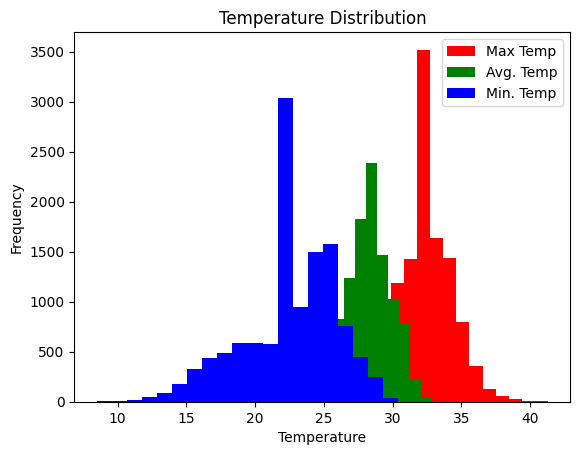

In [16]:
import matplotlib.pyplot as plt

temperature_data = weather_data.select("tmax").collect()
temperature_list = [row.tmax for row in temperature_data]
plt.hist(temperature_list, bins=20, color='r')

temperature_data = weather_data.select("tavg").collect()
temperature_list = [row.tavg for row in temperature_data]
plt.hist(temperature_list, bins=20, color='g')

temperature_data = weather_data.select("tmin").collect()
temperature_list = [row.tmin for row in temperature_data]
plt.hist(temperature_list, bins=20, color='b')

plt.legend(['Max Temp', 'Avg. Temp', 'Min. Temp'])
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Temperature Distribution")
plt.show()

In [17]:
from pyspark.sql.functions import *

In [18]:
weather_data = weather_data.withColumn("Date", to_timestamp("time", "dd-MM-yyyy").cast("date"))
weather_data.show()

+---+----------+----+----+------------------+----------+
|_c0|      time|tmin|tavg|              tmax|      Date|
+---+----------+----+----+------------------+----------+
|  0|01-01-1990|17.0|23.2|32.315039551416845|1990-01-01|
|  1|02-01-1990|16.5|22.2|              29.9|1990-01-02|
|  2|03-01-1990|16.3|21.8|              30.7|1990-01-03|
|  3|04-01-1990|17.9|25.4|              31.8|1990-01-04|
|  4|05-01-1990|19.3|26.5|              33.7|1990-01-05|
|  5|06-01-1990|19.8|25.1|              33.5|1990-01-06|
|  6|07-01-1990|18.9|26.0|              33.7|1990-01-07|
|  7|08-01-1990|18.8|26.6|              34.6|1990-01-08|
|  8|09-01-1990|19.0|25.1|              34.4|1990-01-09|
|  9|10-01-1990|19.3|26.8|              34.7|1990-01-10|
| 10|11-01-1990|18.5|25.6|              34.0|1990-01-11|
| 11|12-01-1990|17.5|24.3|              35.0|1990-01-12|
| 12|13-01-1990|16.5|22.4|              34.4|1990-01-13|
| 13|14-01-1990|16.3|25.4|32.315039551416845|1990-01-14|
| 14|15-01-1990|15.0|23.7|     

In [19]:
weather_data = weather_data.withColumn('Year', year(weather_data.Date))
weather_data.show()

+---+----------+----+----+------------------+----------+----+
|_c0|      time|tmin|tavg|              tmax|      Date|Year|
+---+----------+----+----+------------------+----------+----+
|  0|01-01-1990|17.0|23.2|32.315039551416845|1990-01-01|1990|
|  1|02-01-1990|16.5|22.2|              29.9|1990-01-02|1990|
|  2|03-01-1990|16.3|21.8|              30.7|1990-01-03|1990|
|  3|04-01-1990|17.9|25.4|              31.8|1990-01-04|1990|
|  4|05-01-1990|19.3|26.5|              33.7|1990-01-05|1990|
|  5|06-01-1990|19.8|25.1|              33.5|1990-01-06|1990|
|  6|07-01-1990|18.9|26.0|              33.7|1990-01-07|1990|
|  7|08-01-1990|18.8|26.6|              34.6|1990-01-08|1990|
|  8|09-01-1990|19.0|25.1|              34.4|1990-01-09|1990|
|  9|10-01-1990|19.3|26.8|              34.7|1990-01-10|1990|
| 10|11-01-1990|18.5|25.6|              34.0|1990-01-11|1990|
| 11|12-01-1990|17.5|24.3|              35.0|1990-01-12|1990|
| 12|13-01-1990|16.5|22.4|              34.4|1990-01-13|1990|
| 13|14-

In [20]:
weather_data = weather_data.withColumn('Month', month(weather_data.Date))
weather_data.show(35)

+---+----------+------------------+----+------------------+----------+----+-----+
|_c0|      time|              tmin|tavg|              tmax|      Date|Year|Month|
+---+----------+------------------+----+------------------+----------+----+-----+
|  0|01-01-1990|              17.0|23.2|32.315039551416845|1990-01-01|1990|    1|
|  1|02-01-1990|              16.5|22.2|              29.9|1990-01-02|1990|    1|
|  2|03-01-1990|              16.3|21.8|              30.7|1990-01-03|1990|    1|
|  3|04-01-1990|              17.9|25.4|              31.8|1990-01-04|1990|    1|
|  4|05-01-1990|              19.3|26.5|              33.7|1990-01-05|1990|    1|
|  5|06-01-1990|              19.8|25.1|              33.5|1990-01-06|1990|    1|
|  6|07-01-1990|              18.9|26.0|              33.7|1990-01-07|1990|    1|
|  7|08-01-1990|              18.8|26.6|              34.6|1990-01-08|1990|    1|
|  8|09-01-1990|              19.0|25.1|              34.4|1990-01-09|1990|    1|
|  9|10-01-1990|

In [21]:
weather_data = weather_data.withColumn('Quarter', quarter(weather_data.Date))
weather_data.show()

+---+----------+----+----+------------------+----------+----+-----+-------+
|_c0|      time|tmin|tavg|              tmax|      Date|Year|Month|Quarter|
+---+----------+----+----+------------------+----------+----+-----+-------+
|  0|01-01-1990|17.0|23.2|32.315039551416845|1990-01-01|1990|    1|      1|
|  1|02-01-1990|16.5|22.2|              29.9|1990-01-02|1990|    1|      1|
|  2|03-01-1990|16.3|21.8|              30.7|1990-01-03|1990|    1|      1|
|  3|04-01-1990|17.9|25.4|              31.8|1990-01-04|1990|    1|      1|
|  4|05-01-1990|19.3|26.5|              33.7|1990-01-05|1990|    1|      1|
|  5|06-01-1990|19.8|25.1|              33.5|1990-01-06|1990|    1|      1|
|  6|07-01-1990|18.9|26.0|              33.7|1990-01-07|1990|    1|      1|
|  7|08-01-1990|18.8|26.6|              34.6|1990-01-08|1990|    1|      1|
|  8|09-01-1990|19.0|25.1|              34.4|1990-01-09|1990|    1|      1|
|  9|10-01-1990|19.3|26.8|              34.7|1990-01-10|1990|    1|      1|
| 10|11-01-1

In [22]:
# weather_data = weather_data.withColumn("Date", to_timestamp(col("Date"))).withColumn("Day", date_format(col("Date"), "d"))
weather_data = weather_data.withColumn("Day", dayofmonth(col("date")))
weather_data.show()

+---+----------+----+----+------------------+----------+----+-----+-------+---+
|_c0|      time|tmin|tavg|              tmax|      Date|Year|Month|Quarter|Day|
+---+----------+----+----+------------------+----------+----+-----+-------+---+
|  0|01-01-1990|17.0|23.2|32.315039551416845|1990-01-01|1990|    1|      1|  1|
|  1|02-01-1990|16.5|22.2|              29.9|1990-01-02|1990|    1|      1|  2|
|  2|03-01-1990|16.3|21.8|              30.7|1990-01-03|1990|    1|      1|  3|
|  3|04-01-1990|17.9|25.4|              31.8|1990-01-04|1990|    1|      1|  4|
|  4|05-01-1990|19.3|26.5|              33.7|1990-01-05|1990|    1|      1|  5|
|  5|06-01-1990|19.8|25.1|              33.5|1990-01-06|1990|    1|      1|  6|
|  6|07-01-1990|18.9|26.0|              33.7|1990-01-07|1990|    1|      1|  7|
|  7|08-01-1990|18.8|26.6|              34.6|1990-01-08|1990|    1|      1|  8|
|  8|09-01-1990|19.0|25.1|              34.4|1990-01-09|1990|    1|      1|  9|
|  9|10-01-1990|19.3|26.8|              

In [23]:
weather_data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Day: integer (nullable = true)



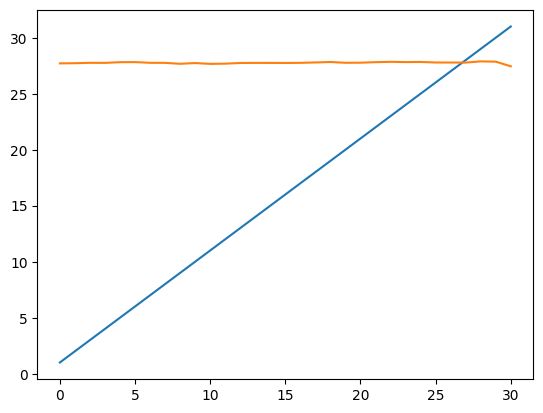

In [24]:
avg_temp = weather_data.groupBy("Day").agg(avg("tavg").alias("Avg")).orderBy('Day')
plt.plot(avg_temp.toPandas())

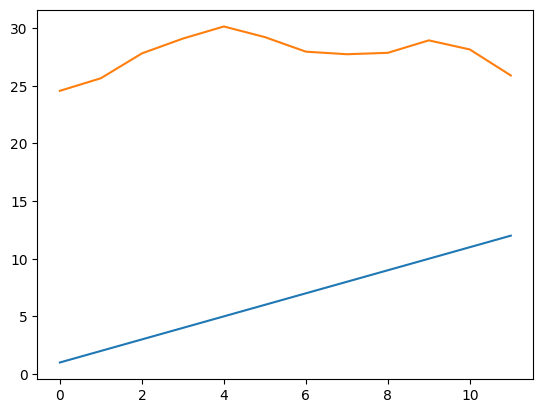

In [27]:
avg_temp = weather_data.groupBy("Month").agg(avg("tavg").alias("Month")).orderBy('Month')
plt.plot(avg_temp.toPandas())

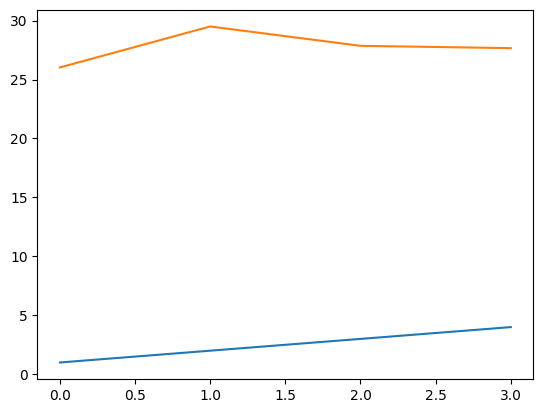

In [28]:
avg_temp = weather_data.groupBy("Quarter").agg(avg("tavg").alias("Quarter")).orderBy('Quarter')
plt.plot(avg_temp.toPandas())

In [30]:
max_temp_date = weather_data.orderBy(desc("tmax")).first()["Date"]
print("The date with the highest maximum temperature is:", max_temp_date)

min_temp_date = weather_data.orderBy(asc("tmin")).first()["Date"]
print("The date with the lowest minimum temperature is:", min_temp_date)

The date with the highest maximum temperature is: 2011-03-16
The date with the lowest minimum temperature is: 2008-02-08


In [31]:
threshold = 20
filtered_data = weather_data.filter(weather_data["tmin"] < threshold)
filtered_data.show()

+---+----------+----+----+------------------+----------+----+-----+-------+---+
|_c0|      time|tmin|tavg|              tmax|      Date|Year|Month|Quarter|Day|
+---+----------+----+----+------------------+----------+----+-----+-------+---+
|  0|01-01-1990|17.0|23.2|32.315039551416845|1990-01-01|1990|    1|      1|  1|
|  1|02-01-1990|16.5|22.2|              29.9|1990-01-02|1990|    1|      1|  2|
|  2|03-01-1990|16.3|21.8|              30.7|1990-01-03|1990|    1|      1|  3|
|  3|04-01-1990|17.9|25.4|              31.8|1990-01-04|1990|    1|      1|  4|
|  4|05-01-1990|19.3|26.5|              33.7|1990-01-05|1990|    1|      1|  5|
|  5|06-01-1990|19.8|25.1|              33.5|1990-01-06|1990|    1|      1|  6|
|  6|07-01-1990|18.9|26.0|              33.7|1990-01-07|1990|    1|      1|  7|
|  7|08-01-1990|18.8|26.6|              34.6|1990-01-08|1990|    1|      1|  8|
|  8|09-01-1990|19.0|25.1|              34.4|1990-01-09|1990|    1|      1|  9|
|  9|10-01-1990|19.3|26.8|              

In [32]:
monthly_avg_temp = weather_data.groupBy(month("Date").alias("Month")).agg(avg("tavg").alias("Monthly_Avg_Temp"))
hottest_month = monthly_avg_temp.orderBy(desc("Monthly_Avg_Temp")).first()["Month"]
coldest_month = monthly_avg_temp.orderBy("Monthly_Avg_Temp").first()["Month"]
print("The hottest month is:", hottest_month)
print("The coldest month is:", coldest_month)

The hottest month is: 5
The coldest month is: 1


In [33]:
daily_temp_range = weather_data.withColumn("Temp_Range", col("tmax") - col("tmin"))
daily_temp_range.show()

+---+----------+----+----+------------------+----------+----+-----+-------+---+------------------+
|_c0|      time|tmin|tavg|              tmax|      Date|Year|Month|Quarter|Day|        Temp_Range|
+---+----------+----+----+------------------+----------+----+-----+-------+---+------------------+
|  0|01-01-1990|17.0|23.2|32.315039551416845|1990-01-01|1990|    1|      1|  1|15.315039551416845|
|  1|02-01-1990|16.5|22.2|              29.9|1990-01-02|1990|    1|      1|  2|13.399999999999999|
|  2|03-01-1990|16.3|21.8|              30.7|1990-01-03|1990|    1|      1|  3|14.399999999999999|
|  3|04-01-1990|17.9|25.4|              31.8|1990-01-04|1990|    1|      1|  4|13.900000000000002|
|  4|05-01-1990|19.3|26.5|              33.7|1990-01-05|1990|    1|      1|  5|14.400000000000002|
|  5|06-01-1990|19.8|25.1|              33.5|1990-01-06|1990|    1|      1|  6|              13.7|
|  6|07-01-1990|18.9|26.0|              33.7|1990-01-07|1990|    1|      1|  7|14.800000000000004|
|  7|08-01

In [34]:
threshold = 30
num_days_above_threshold = weather_data.filter(weather_data["tmax"] > threshold).count()
print("The number of days where the temperature was above", threshold, "degrees is:", num_days_above_threshold)

The number of days where the temperature was above 30 degrees is: 10293


<Axes: >

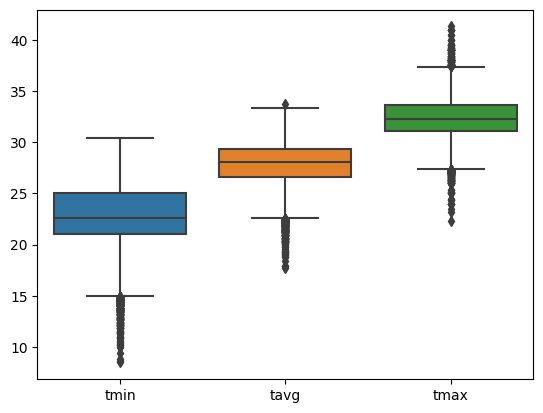

In [35]:
temp_data = weather_data.select("tmin", "tavg", "tmax").toPandas()
sns.boxplot(data=temp_data)

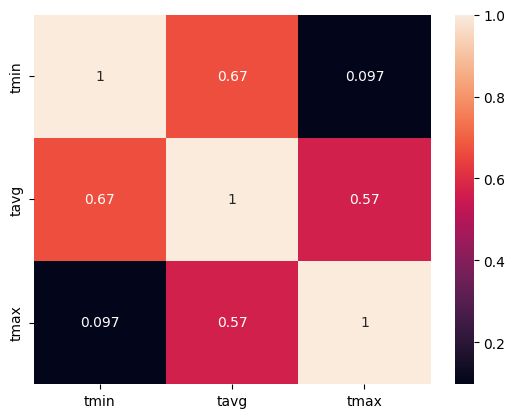

In [37]:
correlation_data = weather_data.select("tmin", "tavg", "tmax")
correlation_matrix = correlation_data.toPandas().corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [38]:
from pyspark.sql.window import Window

In [39]:
weather_data = weather_data.orderBy("Date")
weather_data = weather_data.withColumn("Temp_Diff", abs(col("Tavg") - lag("Tavg", 1).over(Window.orderBy("Date"))))
max_increase = weather_data.orderBy(desc("Temp_Diff")).first()
max_decrease = weather_data.orderBy("Temp_Diff").first()
print("The day with the highest temperature increase is:", max_increase["Date"])
print("The day with the highest temperature decrease is:", max_decrease["Date"])

The day with the highest temperature increase is: 2021-12-01
The day with the highest temperature decrease is: 1990-01-01


In [40]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

# create a new column for the day of the year (1-365)
weather_data = weather_data.withColumn("DayOfYear", dayofyear("Date"))

# prepare the data for regression
assembler = VectorAssembler(inputCols=["DayOfYear"], outputCol="features")
lr = LinearRegression(featuresCol="features", labelCol="tavg")
pipeline = Pipeline(stages=[assembler, lr])

train_data, test_data = weather_data.randomSplit([0.8, 0.2], seed=42)

# train the model and make predictions on the test set
model = pipeline.fit(train_data)
predictions = model.transform(test_data)

x = range(predictions.count())
y_actual = predictions.select("tavg").rdd.flatMap(lambda x: x).collect()
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
plt.plot(x, y_actual, label="Actual")
plt.plot(x, y_pred, label="Predicted")
plt.xlabel("Index")
plt.ylabel("Temperature")
plt.legend()
plt.show()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 114.0 failed 1 times, most recent failure: Lost task 0.0 in stage 114.0 (TID 71) (LAPTOP executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 15 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:971)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2263)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2284)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2303)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2328)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1019)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:405)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1018)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:76)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:52)
	at java.base/java.lang.reflect.Method.invoke(Method.java:578)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1589)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:192)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:166)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:92)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:694)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:738)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:690)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:655)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:631)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:588)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:546)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:179)
	... 15 more


In [41]:
# evaluate the model
evaluator = RegressionEvaluator(labelCol="tavg")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
print(f"RMSE: {rmse:.2f}")

RMSE: 2.23


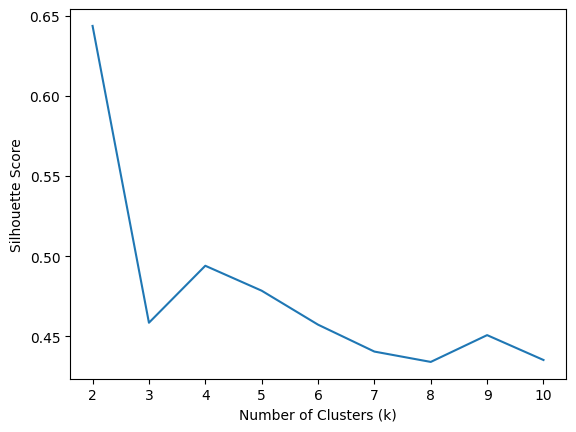

In [42]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

# prepare the data for clustering
assembler = VectorAssembler(inputCols=["tmin", "tavg", "tmax"], outputCol="features")
data = assembler.transform(weather_data).select("features")

# train k-means models for k = 2 to 10 and evaluate their performance
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(data)
    predictions = model.transform(data)
    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# plot the silhouette scores for each value of k
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
kmeans = KMeans(featuresCol="features", predictionCol="cluster", k=3, seed=123)
kmeans_model = kmeans.fit(data)

# make predictions on the data
predictions = kmeans_model.transform(data)

# display the clusters
predictions.groupBy("cluster").count().show()

In [43]:
# prepare the data for clustering analysis
assembler = VectorAssembler(inputCols=["tmin", "tavg", "tmax"], outputCol="features")
data = assembler.transform(weather_data).select("features")

# fit a K-means clustering model to the data
kmeans = KMeans(k=3, seed=123)
kmeans_model = kmeans.fit(data)

# predict the cluster labels for each data point
clustered_data = kmeans_model.transform(data)

# display the clustered data
clustered_data.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[17.0,23.2,32.315...|         1|
|    [16.5,22.2,29.9]|         1|
|    [16.3,21.8,30.7]|         1|
|    [17.9,25.4,31.8]|         1|
|    [19.3,26.5,33.7]|         1|
|    [19.8,25.1,33.5]|         1|
|    [18.9,26.0,33.7]|         1|
|    [18.8,26.6,34.6]|         1|
|    [19.0,25.1,34.4]|         1|
|    [19.3,26.8,34.7]|         1|
|    [18.5,25.6,34.0]|         1|
|    [17.5,24.3,35.0]|         1|
|    [16.5,22.4,34.4]|         1|
|[16.3,25.4,32.315...|         1|
|    [15.0,23.7,32.4]|         1|
|    [15.8,24.0,33.5]|         1|
|    [16.7,24.8,34.1]|         1|
|    [16.3,23.8,34.8]|         1|
|    [17.5,25.5,35.2]|         1|
|    [16.0,25.2,34.4]|         1|
+--------------------+----------+
only showing top 20 rows



In [44]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt

assembler = VectorAssembler(inputCols=["tmin", "tmax"], outputCol="features")
transformed_data = assembler.transform(weather_data)

# Split data into train and test sets
train_data, test_data = transformed_data.randomSplit([0.8, 0.2])

# Create a RandomForestRegressor object
rf = RandomForestRegressor(featuresCol="features", labelCol="tavg")

# Set up the parameter grid for the random forest regressor
param_grid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

# Set up the cross-validation object
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=param_grid,
                          evaluator=RegressionEvaluator(labelCol="tavg", metricName="rmse"),
                          numFolds=3)

# Train the model using the cross-validation object and the training data
cv_model = crossval.fit(train_data)

# Use the test data to evaluate the model
predictions = cv_model.transform(test_data)

# Evaluate the model using the root mean squared error (RMSE)
evaluator = RegressionEvaluator(labelCol="tavg", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 1.23814


In [ ]:
# Plot the predicted vs. actual temperatures for the test data
x = predictions.select("Date").rdd.map(lambda x: x[0].strftime('%Y-%m-%d')).collect()
y_actual = predictions.select("tavg").rdd.map(lambda x: x[0]).collect()
y_predicted = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()
plt.figure(figsize=(10,5))
plt.plot(x, y_actual, label="Actual Temperature")
plt.plot(x, y_predicted, label="Predicted Temperature")
plt.title("Random Forest Regressor - Predicted vs Actual Temperature")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.legend()
plt.show()

# Plot the feature importance for the trained model
feature_importances = cv_model.bestModel.featureImportances
feature_names = ["Min. Temperature", "Max. Temperature"]
plt.figure(figsize=(8,4))
plt.bar(feature_names, feature_importances)
plt.title("Random Forest Regressor - Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

In [45]:
# prepare the data for time series forecasting
data = weather_data.select("Date", "tavg")
data = data.withColumn("Year", year(col("Date"))).withColumn("Month", month(col("Date"))).withColumn("Day", dayofmonth(col("Date")))

assembler = VectorAssembler(inputCols=["Year", "Month", "Day"], outputCol="features")
data = assembler.transform(data).select("features", "tavg")

# fit a random forest regression model to the entire data
rf = RandomForestRegressor(featuresCol="features", labelCol="tavg", maxDepth=10, numTrees=10, seed=123)
rf_model = rf.fit(data)

# predict the average temperature for the next 7 days
forecast_data = spark.range(1, 16).withColumnRenamed("id", "Day")
forecast_data = forecast_data.withColumn("Year", year(current_date())).withColumn("Month", month(current_date())).withColumn("Date", concat(col("Year"), lit("-"), col("Month"), lit("-"), col("Day")))
forecast_data = assembler.transform(forecast_data).select("features")
forecast_data = rf_model.transform(forecast_data).select("prediction")

# display the forecasted average temperature for the next 7 days
forecast_data.show()

+------------------+
|        prediction|
+------------------+
|29.853256885301125|
|  29.8251421353316|
|29.991475468664937|
|29.969107047612304|
|29.967773714278973|
|29.967773714278973|
| 29.80409568397594|
|29.735273992315847|
| 29.81506939720031|
|29.794418569739825|
| 29.57008116301903|
|29.772292815330758|
|30.049306822121927|
|30.049306822121927|
|29.957727588712316|
+------------------+



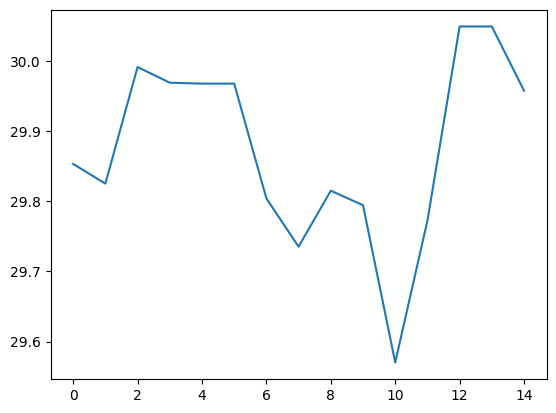

In [46]:
plt.plot(forecast_data.toPandas())